### **Ego4D Dataset Visualization**

In [1]:
import glob
import os
import json
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from projectaria_tools.core import calibration
import cv2
import pandas as pd

DATA_ROOT_DIR = "../"

def out_boundary_check(kpts, img_shape):
    """
    For those out-of-boundary kpts, set it as None
    Input:
        kpts: (N,2) numpy array of kpts
        img_shape: (2,) H and W of images
    Output:
        new_kpts: (N,2)
    """
    # Set None kpts as -1
    kpts = kpts.copy()
    invalid_idx = np.any(kpts == None, axis=1)
    kpts[invalid_idx] = -1
    # Get flag of those out-bound kpts
    x_out_bound = np.logical_or(kpts[:,0] < 0, kpts[:,0] >= img_shape[1])
    y_out_bound = np.logical_or(kpts[:,1] < 0, kpts[:,1] >= img_shape[0])
    out_bound_flag = np.logical_or(x_out_bound, y_out_bound)
    # Set out-bound kpts as None
    new_kpts = kpts.copy()
    new_kpts[out_bound_flag] = None
    return new_kpts


def get_aria_camera_models(aria_path):
    try:
        from projectaria_tools.core import data_provider

        vrs_data_provider = data_provider.create_vrs_data_provider(aria_path)
        aria_camera_model = vrs_data_provider.get_device_calibration()
        slam_left = aria_camera_model.get_camera_calib("camera-slam-left")
        slam_right = aria_camera_model.get_camera_calib("camera-slam-right")
        rgb_cam = aria_camera_model.get_camera_calib("camera-rgb")
    except Exception as e:
        print(
            f"[Warning] Hitting exception {e}. Fall back to old projectaria_tools ..."
        )
        import projectaria_tools

        vrs_data_provider = projectaria_tools.dataprovider.AriaVrsDataProvider()
        vrs_data_provider.openFile(aria_path)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(214, 1)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 1)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        aria_stream_id = projectaria_tools.dataprovider.StreamId(1201, 2)
        vrs_data_provider.setStreamPlayer(aria_stream_id)
        vrs_data_provider.readFirstConfigurationRecord(aria_stream_id)

        assert vrs_data_provider.loadDeviceModel()

        aria_camera_model = vrs_data_provider.getDeviceModel()
        slam_left = aria_camera_model.getCameraCalib("camera-slam-left")
        slam_right = aria_camera_model.getCameraCalib("camera-slam-right")
        rgb_cam = aria_camera_model.getCameraCalib("camera-rgb")

    assert slam_left is not None
    assert slam_right is not None
    assert rgb_cam is not None

    return {
        "1201-1": slam_left,
        "1201-2": slam_right,
        "214-1": rgb_cam,
    }


def aria_original_to_extracted(kpts, img_shape=(1408, 1408)):
    """
    Rotate kpts coordinates from original view (hand horizontal) to extracted view (hand vertical)
    img_shape is the shape of original view image
    """
    # assert len(kpts.shape) == 2, "Only can rotate 2D arrays"
    H, W = img_shape
    new_kpts = kpts.copy()
    new_kpts[:, 0] = H - kpts[:, 1] - 1
    new_kpts[:, 1] = kpts[:, 0]
    return new_kpts

**0. Load Train/Val/Test**

In [5]:
#######################
methods = ['annotation']#'annotation'] # either annotation or automatic
csv_path = "../annotations/egoexo_split_latest_train_val_test.csv"
#######################

def retrieve_name_uid(method, display = True):
    # Find all take uid
    hand_anno_dir = os.path.join(DATA_ROOT_DIR, f"annotations/ego_pose/hand/{method}/")
    all_take_uid = [k[:-5] for  k in os.listdir(hand_anno_dir)]
    # Find all takes name
    takes = json.load(open(os.path.join(DATA_ROOT_DIR, "takes.json")))
    name_uid_dict = {each_take['root_dir'] : each_take['take_uid'] for each_take in takes if each_take["take_uid"] in all_take_uid}
    # Display info
    if display:
        print("="*10,'Available takes:', "="*10)
        for k in name_uid_dict.keys():
            print(k)
    return name_uid_dict 

def fetch_train_val_test(name_uid_dict, csv_path, splits = {}):
    df = pd.read_csv(csv_path)
    for name in name_uid_dict:
        take_uid = name_uid_dict[name]
        split = df[df['take_uid'] == take_uid]['split'].values
        if len(split) > 0:
            splits[split[0]] = splits.get(split[0],[])+[name]
    return splits


In [6]:
splits = {}
for method in methods:
    name_uid_dict = retrieve_name_uid(method, False)
    splits = fetch_train_val_test(name_uid_dict, csv_path, splits)
for key in splits:
    print(key, len(splits[key]))

TRAIN 4
TEST 5


In [3]:
splits = {}
for method in methods:
    name_uid_dict = retrieve_name_uid(method, False)
    splits = fetch_train_val_test(name_uid_dict, csv_path, splits)
for key in splits:
    print(key, len(splits[key]))

VAL 41
TRAIN 181
TEST 76


In [ ]:
import glob
import json

for file in glob.glob("../annotations/annotation_with_box/*")

**1. Load 2D & 3D hand annotation (aria)**

In [4]:
#################
selected_take = 'upenn_0721_Piano_1_3'
hand_order = ['right','left']
finger_dict = {'wrist': None,
               'thumb':[1,2,3,4],
               'index':[1,2,3,4],
               'middle':[1,2,3,4],
               'ring':[1,2,3,4],
               'pinky':[1,2,3,4]}
#################
def fetch_annotation_pose(selected_take, method):

    # assert os.path.exists(os.path.join(DATA_ROOT_DIR, 'cache', selected_take)), f"Images for {selected_take} hasn't been generateed yet"
    # cam_img_dir = os.path.join(DATA_ROOT_DIR, 'cache', selected_take, 'frames')
    # # all_cam = os.listdir(cam_img_dir)
    # # print("="*10, f'Available cameras for {selected_take}:', "="*10)
    # # for cam in all_cam:
    # #     print(cam)

    # # Log take uid info
    # print(name_uid_dict[selected_take])

    # Load in annotation
    hand_anno_dir = os.path.join(DATA_ROOT_DIR, f"annotations/ego_pose/hand/{method}/")
    selected_take_anno = json.load(open(os.path.join(hand_anno_dir, f"{name_uid_dict[selected_take]}.json")))
    # Load in camera pose
    selected_camera_pose = json.load(open(os.path.join(DATA_ROOT_DIR, "annotations/ego_pose/hand/camera_pose", f"{name_uid_dict[selected_take]}.json")))

    return selected_take_anno, selected_camera_pose

In [29]:
def load_kpts(selected_take_anno, cam = 'aria'):
# Load hand 2D & 3D kpts from json file
    hand_2d_kpts = {} # ~ N Dict ~ # of cams ~ (42,2)
    hand_3d_kpts = {} # ~ N ~ (42,3)
    #all_anno_cam = set()
    count = 0
    for frame_idx, curr_frame_anno in selected_take_anno.items():
        # Load 3D kpts first to skip frames without 3D annotations
        #print(curr_frame_anno[0].keys())
        try:
            curr_frame_3d_anno = curr_frame_anno[0]['annotation3D']
        except:
            continue
        curr_frame_3d = []
        # Collect hand kpts for current view with specified order
        for hand in hand_order:
            for finger, finger_range in finger_dict.items():
                if finger_range:
                    for finger_range_idx in finger_range:
                        finger_k_json = f"{hand}_{finger}_{finger_range_idx}"
                        if finger_k_json in curr_frame_3d_anno.keys():
                            curr_frame_3d.append([curr_frame_3d_anno[finger_k_json]['x'],
                                                curr_frame_3d_anno[finger_k_json]['y'],
                                                curr_frame_3d_anno[finger_k_json]['z']])
                        else:
                            curr_frame_3d.append([None, None, None])
                else:
                    finger_k_json = f"{hand}_{finger}"
                    if finger_k_json in curr_frame_3d_anno.keys():
                        curr_frame_3d.append([curr_frame_3d_anno[finger_k_json]['x'],
                                            curr_frame_3d_anno[finger_k_json]['y'],
                                            curr_frame_3d_anno[finger_k_json]['z']])
                    else:
                        curr_frame_3d.append([None, None, None])

        curr_frame_2d = {}
        # Load in 2D kpts on all camera views
        try:
            curr_frame_2d_anno = curr_frame_anno[0]['annotation2D']
            cam = None
            for val in curr_frame_2d_anno.keys():
                if 'aria' in val:
                    cam = val
            cam_anno = curr_frame_2d_anno[cam]
        except:
            print(curr_frame_2d_anno.keys())
            continue
        curr_cam_2d_kpts = []
        #all_anno_cam.add(cam) # Keep track of all valid camera name in annotation
        # Collect hand kpts for current view with specified order
        for hand in hand_order:
            for finger, finger_range in finger_dict.items():
                if finger_range:
                    for finger_range_idx in finger_range:
                        finger_k_json = f"{hand}_{finger}_{finger_range_idx}"
                        if finger_k_json in cam_anno.keys():
                            curr_cam_2d_kpts.append([cam_anno[finger_k_json]['x'],
                                                    cam_anno[finger_k_json]['y']])
                        else:
                            curr_cam_2d_kpts.append([None, None])
                else:
                    finger_k_json = f"{hand}_{finger}"
                    if finger_k_json in cam_anno.keys():
                        curr_cam_2d_kpts.append([cam_anno[finger_k_json]['x'],
                                                cam_anno[finger_k_json]['y']])
                    else:
                        curr_cam_2d_kpts.append([None, None])
        curr_cam_2d_kpts = np.array(curr_cam_2d_kpts)
        curr_frame_2d[cam] = curr_cam_2d_kpts

        count += 1
        hand_3d_kpts[frame_idx] = np.array(curr_frame_3d)
        hand_2d_kpts[frame_idx] = curr_frame_2d
    # all_anno_cam = list(all_anno_cam)
    # print('All camera names in annotation: ', all_anno_cam)
    print(f"Retrieved {count} out of {len(selected_take_anno)} frames that were fully annotated.")
    return hand_2d_kpts, hand_3d_kpts

In [31]:
#######################
method = 'annotation' # either annotation or automatic
#######################

# Find all take uid
hand_anno_dir = os.path.join(DATA_ROOT_DIR, f"annotations/ego_pose/hand/{method}/")
all_take_uid = [k[:-5] for k in os.listdir(hand_anno_dir)]
# Find all takes name
takes = json.load(open(os.path.join(DATA_ROOT_DIR, "takes.json")))
take_to_uid = {each_take['root_dir'] : each_take['take_uid'] for each_take in takes if each_take["take_uid"] in all_take_uid}
uid_to_take = {uid:take for take, uid in take_to_uid.items()}
# Display info
print("="*10,'Available takes:', "="*10)
for k, uid in take_to_uid.items():
    print(f"{k}:\t {uid}")

# Load in train/val/test split
takes_df = pd.read_csv(os.path.join(DATA_ROOT_DIR, 'annotations/egoexo_split_latest_train_val_test.csv'))
train_df = takes_df[takes_df['split']=='TRAIN']
val_df = takes_df[takes_df['split']=='VAL']
test_df = takes_df[takes_df['split']=='TEST']

# All train take uids
all_train_uid = list(train_df['take_uid'])
all_val_uid = list(val_df['take_uid'])
all_test_uid = list(test_df['take_uid'])
split_take_dict = {'train':all_train_uid, 'val':all_val_uid, 'test':all_test_uid}

# Split set summary
print(f'Number of available undistorted images with method={method}:')
for split_name, split_uid in split_take_dict.items():
    available_uid = [curr_take for curr_take in all_take_uid if curr_take in split_uid]
    available_name = [uid_to_take[curr_uid] for curr_uid in available_uid]
    # Image count
    cnt = 0
    for t in available_name:
        img_dir = os.path.join(DATA_ROOT_DIR, f"aria_undistorted_images/{method}", t)
        cnt += len(os.listdir(img_dir))
    print(f'{split_name}: {cnt}')

========== Available takes: ==========
georgiatech_covid_06_11:	 816dd81e-93b1-433c-83ff-264ae404a3bf
georgiatech_covid_06_13:	 bcfb6839-3c09-4d42-9d9c-59042f6ab721
nus_cpr_08_2:	 9bd3f0f1-531c-47e1-be1c-2b4eae001bd5
upenn_0710_Guitar_1_3:	 e3cb859e-73ca-4cef-8c08-296bafdb43cd
upenn_0710_Guitar_1_4:	 d2218738-2af2-4585-bd1c-af8ad10d7827
upenn_0710_Guitar_1_5:	 3940a14c-f0ae-4636-8f03-52daa071f084
upenn_0715_Piano_1_4:	 989b038e-d46c-4433-b968-87b58a4c7037
upenn_0717_Piano_1_2:	 354f076e-079f-440d-bd38-97ddfcd19002
upenn_0717_Piano_1_3:	 7014a547-6f84-48cb-bc91-28012c4cce06
upenn_0717_Piano_2_2:	 f0ebc587-3687-494d-a707-2a5d52b64719
upenn_0717_Piano_2_3:	 c507b073-7bf9-40db-8537-de599b6f6565
upenn_0718_Violin_2_5:	 794b3bd3-eac9-4d0d-9789-bd068bff3944
upenn_0721_Piano_1_2:	 c53a1199-5ca1-4aa8-ac4e-38227ff44689
upenn_0721_Piano_1_3:	 6e5211e1-72d8-4032-ba56-b4095c0f2b36
upenn_0721_Piano_2_2:	 a8d04142-fc0b-4ad4-acaa-8c17424411ff
upenn_0721_Piano_2_3:	 e5beffc8-2cc5-4cc5-9e0e-b22b843aaa4c

**2. Load camera pose**

In [30]:
kpts_2d = {}
kpts_3d = {}
for split in splits:
    kpts_2d[split] = {}
    kpts_3d[split] = {}
    for selected_take in splits[split]:

        selected_take_anno, selected_camera_pose = fetch_annotation_pose(selected_take, method)

        print(selected_take, end=": ")
        hand_2d_kpts, hand_3d_kpts = load_kpts(selected_take_anno)
        kpts_2d[split][selected_take] = hand_2d_kpts
        kpts_3d[split][selected_take] = hand_3d_kpts

cmu_soccer11_1: Retrieved 142 out of 374 frames that were fully annotated.
cmu_soccer11_3: Retrieved 45 out of 94 frames that were fully annotated.
georgiatech_covid_02_2: Retrieved 3042 out of 3071 frames that were fully annotated.
georgiatech_covid_02_4: Retrieved 4370 out of 4420 frames that were fully annotated.
iiith_cooking_02_1: Retrieved 5198 out of 6005 frames that were fully annotated.
iiith_cooking_02_3: Retrieved 5140 out of 5771 frames that were fully annotated.
uniandes_bouldering_012_11: Retrieved 708 out of 935 frames that were fully annotated.
uniandes_bouldering_012_12: Retrieved 391 out of 483 frames that were fully annotated.
uniandes_bouldering_012_13: Retrieved 589 out of 942 frames that were fully annotated.
uniandes_bouldering_012_14: Retrieved 601 out of 906 frames that were fully annotated.
uniandes_bouldering_012_15: Retrieved 480 out of 692 frames that were fully annotated.
uniandes_bouldering_012_16: Retrieved 519 out of 588 frames that were fully annotated

KeyboardInterrupt: 

In [18]:
count = 0
for frame in selected_take_anno:
    #print(selected_take_anno[frame][0].keys())
    if 'annotation3D' in selected_take_anno[frame][0].keys():
        #print(frame)
        count += 1
count/len(selected_take_anno)

0.37967914438502676

In [10]:
camera_pose = {}
for frame_idx, curr_cam_pose_anno in selected_camera_pose.items():
    camera_pose_frame_ith = {}
    for each_cam in all_anno_cam:
        # Extract intrinsic and extrinsic
        curr_cam_intrinsic = np.array(curr_cam_pose_anno[each_cam]['camera_intrinsics'])
        curr_cam_extrinsics = np.array(curr_cam_pose_anno[each_cam]['camera_extrinsics'])
        # Compute camera projection matrix
        world_to_img_tran = curr_cam_intrinsic @ curr_cam_extrinsics
        # Append result
        camera_pose_frame_ith[each_cam] = world_to_img_tran
    camera_pose[frame_idx] = camera_pose_frame_ith

NameError: name 'selected_camera_pose' is not defined

**3. 2D & 3D visualization on aria01_rgb**

The provided 2D kpts annotation is in original view (where hand is horizontal), and the extracted aria images are in extracted view (where hands are vertial)

[VRSIndexRecord][WARNING]: 4 record(s) not sorted properly. Sorting index.
[MultiRecordFileReader][DEBUG]: Opened file './captures/upenn_0721_Piano_1/videos/aria01.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1 activated
[VrsDataProvider][INFO]: streamId 214-1 activated
[VrsDataProvider][INFO]: streamId 231-1 activated
[VrsDataProvider][INFO]: streamId 247-1 activated
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1 activated
[VrsDataProvider][INFO]: streamId 1201-2 activated
[VrsDataProvider][INFO]: streamId 1202-1 activated
[VrsDataProvider][INFO]: streamId 1202-2 activated
[VrsDataProvider][INFO]: streamId 1203-1 activated


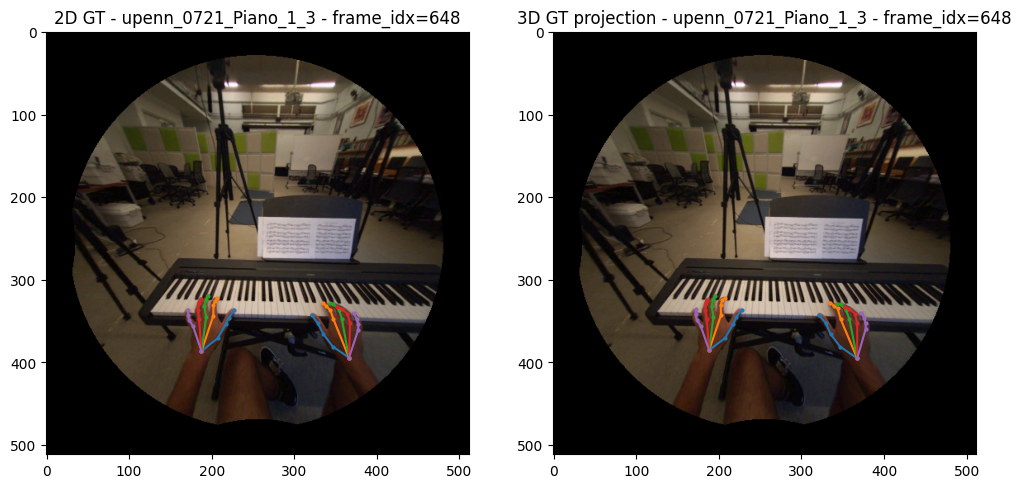

In [9]:
##################################
rand_frame_idx = 0 # 34
aria_in_original = False
out_bound_check = True
##################################

# Real frame index
frame_key = list(hand_2d_kpts.keys())[rand_frame_idx]
right_hand_index = np.array([[0,1,2,3,4],
                             [0,5,6,7,8],
                             [0,9,10,11,12],
                             [0,13,14,15,16],
                             [0,17,18,19,20]])
left_hand_index = right_hand_index + 21
hand_plot_index = {'right_hand':right_hand_index, 'left_hand':left_hand_index}
color_dict = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple'}

# Load image
rand_img_path = os.path.join(DATA_ROOT_DIR, 'cache', selected_take, 'frames', 'aria01_rgb', f"{int(frame_key):06d}.jpg")
image = np.array(Image.open(rand_img_path).rotate(90))

# undistort aria-rgb images
capture_name = '_'.join(selected_take.split('_')[:-1])
vrs_path = os.path.join(DATA_ROOT_DIR, 'captures', capture_name, 'videos/aria01.vrs')
aria_rgb_calib = get_aria_camera_models(vrs_path)['214-1']
pinhole = calibration.get_linear_camera_calibration(512, 512, 150)
undistorted_image = calibration.distort_by_calibration(image, pinhole, aria_rgb_calib)
undistorted_image = cv2.rotate(undistorted_image, cv2.ROTATE_90_CLOCKWISE) if not aria_in_original else undistorted_image

# Visualization 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

### 2D visualization ###
curr_hand_2d_kpts = hand_2d_kpts[frame_key]['aria01'].copy()
none_idx = np.any(curr_hand_2d_kpts==None, axis=1)
curr_hand_2d_kpts[none_idx] = 0
plt.imshow(undistorted_image)
plt.title(f"2D GT - {selected_take} - frame_idx={frame_key}")
rand_hand_kpts = curr_hand_2d_kpts if aria_in_original else aria_original_to_extracted(curr_hand_2d_kpts, undistorted_image.shape[:2])
# Out-bound check
rand_hand_kpts = out_boundary_check(rand_hand_kpts, undistorted_image.shape[:2]) if out_bound_check else rand_hand_kpts
rand_hand_kpts[none_idx] = None
# Plot hand kpts
for _, all_finger_index in hand_plot_index.items():
    for i, each_finger_index in enumerate(all_finger_index):
        curr_finger_kpts = rand_hand_kpts[each_finger_index]
        plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=2, color=color_dict[i])
# plt.axis('off')

### 3D visualization ###
plt.subplot(1,2,2)
curr_hand_3d_kpts = hand_3d_kpts[frame_key]
curr_tran = camera_pose[frame_key]['aria01']
# Projection
none_idx = np.any(curr_hand_3d_kpts==None, axis=1)
curr_hand_3d_kpts[none_idx] = 0
proj_hand_2d_kpts = curr_tran @ np.append(curr_hand_3d_kpts, np.ones((curr_hand_3d_kpts.shape[0], 1)), axis=1).T
proj_hand_2d_kpts = (proj_hand_2d_kpts[:2,:] / proj_hand_2d_kpts[2,:]).T
# Plot
plt.imshow(undistorted_image)
plt.title(f"3D GT projection - {selected_take} - frame_idx={frame_key}")
proj_hand_2d_kpts = proj_hand_2d_kpts if aria_in_original else aria_original_to_extracted(proj_hand_2d_kpts, undistorted_image.shape[:2])
# Out-boung check
proj_hand_2d_kpts = out_boundary_check(proj_hand_2d_kpts, undistorted_image.shape[:2]) if out_bound_check else proj_hand_2d_kpts
proj_hand_2d_kpts[none_idx] = None
# Plot hand kpts
for _, all_finger_index in hand_plot_index.items():
    for i, each_finger_index in enumerate(all_finger_index):
        curr_finger_kpts = proj_hand_2d_kpts[each_finger_index]
        plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=2, color=color_dict[i])
# plt.axis('off')